In [ ]:
import os, glob, h5py, cv2
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim_metric, peak_signal_noise_ratio as psnr_metric


In [ ]:
def build_dehazenet():
    return {
        'feature': nn.ModuleList([nn.Conv2d(3, 4, kernel_size=5, padding=2) for _ in range(4)]),
        'multi': nn.ModuleList([
            nn.Conv2d(4, 8, kernel_size=3, padding=1),
            nn.Conv2d(4, 8, kernel_size=5, padding=2),
            nn.Conv2d(4, 8, kernel_size=7, padding=3)
        ]),
        'extremum': nn.MaxPool2d(kernel_size=7, stride=1, padding=3),
        'regressor': nn.Conv2d(24, 1, kernel_size=1)
    }

def forward_dehazenet(x, net):
    feat_maps = torch.stack([conv(x) for conv in net['feature']], dim=0)
    feat_out, _ = torch.max(feat_maps, dim=0)
    multi_outs = [conv(feat_out) for conv in net['multi']]
    multi_cat = torch.cat(multi_outs, dim=1)
    local_max = net['extremum'](multi_cat)
    out = net['regressor'](local_max)
    out = torch.clamp(out, 0, 1)
    return out

In [ ]:
def prepare_dataset(hazy_dir, trans_dir, limit=200):
    imgs, t_maps = [], []
    mat_files = sorted(glob.glob(os.path.join(trans_dir, "*.mat")))
    for mat_path in mat_files:
        base = os.path.splitext(os.path.basename(mat_path))[0]
        hazy_imgs = glob.glob(os.path.join(hazy_dir, f"{base}_*.jpg"))
        if not hazy_imgs: continue
        with h5py.File(mat_path, 'r') as f:
            t = np.array(f[list(f.keys())[0]]).T
        # Ensure transmission in [0,1]
        t = t / np.max(t)
        t = np.clip(t, 0, 1)
        #t = np.clip(t, 1e-4, 1.0)
        for img_path in hazy_imgs:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
            img = cv2.resize(img, (320,240))
            t_resized = cv2.resize(t, (320,240))
            imgs.append(torch.from_numpy(img).permute(2,0,1).float())
            t_maps.append(torch.from_numpy(t_resized).unsqueeze(0).float())
        if len(imgs) >= limit: break
    return TensorDataset(torch.stack(imgs), torch.stack(t_maps))

In [ ]:
def train_dehazenet(net, train_loader, val_loader, device, epochs=5, lr=1e-4):
    params = []
    for module in net.values():
        if isinstance(module, nn.ModuleList):
            params += list(module.parameters())
        else:
            params += list(module.parameters())
    optimizer = torch.optim.Adam(params, lr=lr)
    criterion = nn.MSELoss()

    for k in net: net[k] = net[k].to(device)
    print(f"\nraining on device: {device}")

    for epoch in range(epochs):
        for k in net: net[k].train()
        train_loss = 0
        for imgs, t_maps in train_loader:
            imgs, t_maps = imgs.to(device), t_maps.to(device)

            preds = forward_dehazenet(imgs, net)

            print(f"[Epoch {epoch+1}] Pred min/max: {preds.min().item():.3f}/{preds.max().item():.3f} | Target min/max: {t_maps.min().item():.3f}/{t_maps.max().item():.3f}")

            loss = criterion(preds, t_maps)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train = train_loss/len(train_loader)

        # Val
        for k in net: net[k].eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, t_maps in val_loader:
                imgs, t_maps = imgs.to(device), t_maps.to(device)
                preds = forward_dehazenet(imgs, net)
                val_loss += criterion(preds, t_maps).item()
        avg_val = val_loss/len(val_loader)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f}")

In [ ]:
def recover_dehazed_image(img, pred_t, t0=0.1):
    dark = np.min(img, axis=2)
    flat = dark.flatten()
    n_top = max(int(len(flat)*0.001),1)
    idx = np.argpartition(flat, -n_top)[-n_top:]
    A = np.max(img.reshape(-1,3)[idx], axis=0)
    pred_t = np.maximum(pred_t, t0)
    J = (img - A*(1 - pred_t[...,np.newaxis])) / pred_t[...,np.newaxis]
    return np.clip(J, 0, 1)

In [ ]:
def predict_and_show(img_path, net, device):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
    img_resized = cv2.resize(img, (320,240))
    inp = torch.from_numpy(img_resized).permute(2,0,1).unsqueeze(0).float().to(device)

    for k in net: net[k].eval()
    with torch.no_grad():
        pred_t = forward_dehazenet(inp, net)
    pred_t = pred_t.squeeze().cpu().numpy()

    dehazed = recover_dehazed_image(img_resized, pred_t)

    dehazed_u8 = (dehazed*255).astype(np.uint8)
    img_u8 = (img_resized*255).astype(np.uint8)
    ssim_val = ssim_metric(img_u8, dehazed_u8, channel_axis=-1)
    psnr_val = psnr_metric(img_u8, dehazed_u8)
    mae_val = mean_absolute_error(img_u8.flatten(), dehazed_u8.flatten())

    print(f"\nSSIM: {ssim_val:.4f} | PSNR: {psnr_val:.2f} dB | MAE: {mae_val:.2f}")

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1); plt.imshow(img_resized); plt.title("Original Hazy")
    plt.subplot(1,3,2); plt.imshow(pred_t, cmap='jet'); plt.title("Predicted Transmission")
    plt.subplot(1,3,3); plt.imshow(dehazed); plt.title("Recovered Dehazed")
    plt.show()


📦 Preparing dataset...
Total samples: 210
🚀 Training DehazeNet ...

✅ Training on device: cuda
[Epoch 1] Pred min/max: 0.028/0.234 | Target min/max: 0.260/0.994
[Epoch 1] Pred min/max: 0.064/0.223 | Target min/max: 0.324/0.983
[Epoch 1] Pred min/max: 0.065/0.231 | Target min/max: 0.260/0.993
[Epoch 1] Pred min/max: 0.077/0.243 | Target min/max: 0.290/0.994
[Epoch 1] Pred min/max: 0.076/0.257 | Target min/max: 0.260/0.994
[Epoch 1] Pred min/max: 0.105/0.246 | Target min/max: 0.290/0.994
[Epoch 1] Pred min/max: 0.112/0.267 | Target min/max: 0.260/0.994
[Epoch 1] Pred min/max: 0.125/0.265 | Target min/max: 0.290/0.994
[Epoch 1] Pred min/max: 0.135/0.284 | Target min/max: 0.310/0.994
[Epoch 1] Pred min/max: 0.145/0.293 | Target min/max: 0.324/0.994
[Epoch 1] Pred min/max: 0.158/0.280 | Target min/max: 0.290/0.994
[Epoch 1] Pred min/max: 0.168/0.290 | Target min/max: 0.260/0.994
[Epoch 1] Pred min/max: 0.174/0.299 | Target min/max: 0.290/0.994
[Epoch 1] Pred min/max: 0.189/0.304 | Target mi

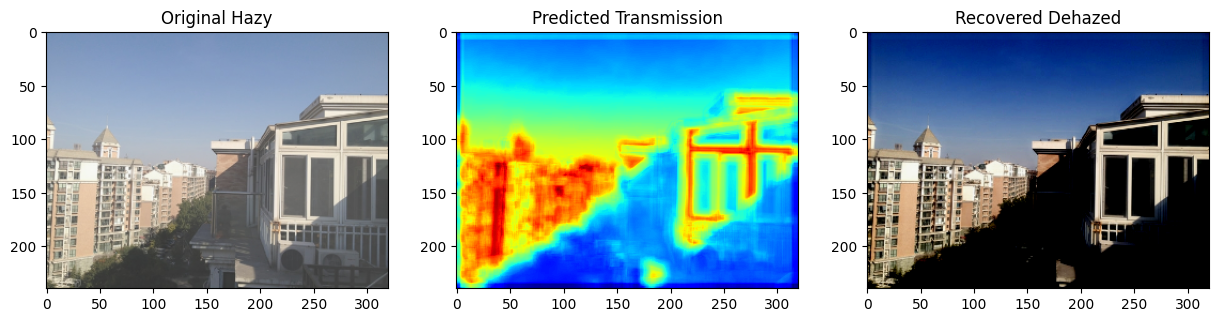

In [1]:


def main():
    hazy_dir = "/kaggle/input/outdoor-training-set-ots-reside/hazy"
    trans_dir = "/kaggle/input/transdata/depth/depth/depth"

    print("Preparing dataset...")
    dataset = prepare_dataset(hazy_dir, trans_dir, limit=200)
    print(f"Total samples: {len(dataset)}")

    train_size = int(0.8*len(dataset))
    val_size = len(dataset)-train_size
    train_set, val_set = random_split(dataset, [train_size,val_size])
    train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=4)

    net = build_dehazenet()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print("Training DehazeNet ...")
    train_dehazenet(net, train_loader, val_loader, device, epochs=5)

    print("Test on image:")
    sample_img = "/kaggle/input/outdoor-training-set-ots-reside/hazy/0138_0.9_0.1.jpg"
    predict_and_show(sample_img, net, device)

if __name__=="__main__":
    main()
